In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars, 1)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

In [66]:
block_size = 3

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(4)
random.shuffle(words)

n1 = int(0.8*len(words)) #80% of words
n2 = int(0.9*len(words)) #90% of words

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182359, 3]) torch.Size([182359])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22994, 3]) torch.Size([22994])


In [4]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)


parameters = C, W1, b1, W2, b2,

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [5]:
lossi = []
def training_model(max_steps, batch_size):
    
    for i in range(max_steps):
    
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
    
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1 #hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function
    
        for p in parameters:
            p.grad = None
        loss.backward()
    
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data += - lr * p.grad
    
        if i % 10000 == 0:
            print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")
    
        lossi.append(loss.log10().item())

training_model(200000, 32)

      0 /  200000 - 26.4902
  10000 /  200000 - 2.7476
  20000 /  200000 - 2.1814
  30000 /  200000 - 2.0946
  40000 /  200000 - 2.4267
  50000 /  200000 - 2.2138
  60000 /  200000 - 2.7386
  70000 /  200000 - 2.5777
  80000 /  200000 - 2.3359
  90000 /  200000 - 2.1164
 100000 /  200000 - 2.3496
 110000 /  200000 - 2.0124
 120000 /  200000 - 2.0058
 130000 /  200000 - 2.0519
 140000 /  200000 - 2.1438
 150000 /  200000 - 2.2542
 160000 /  200000 - 2.2221
 170000 /  200000 - 2.0790
 180000 /  200000 - 2.0429
 190000 /  200000 - 1.9406


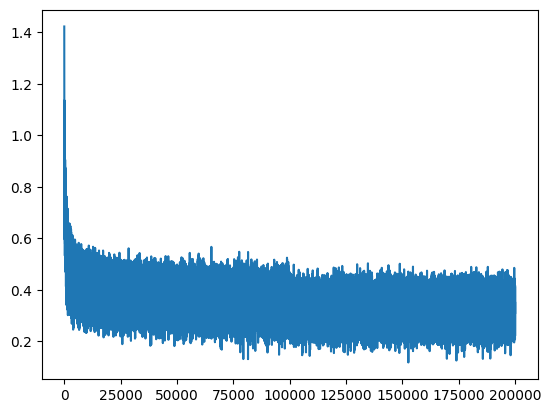

In [6]:
plt.plot(lossi)

In [7]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.12831711769104
val 2.1655433177948


In [8]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimri.
reh.
cassanden.
jazhnen.
deliah.
jareei.
ner.
kipt.
maiir.
kaleigh.
ham.
join.
quintza.
lilea.
jadiq.
wakelo.
dearyn.
xik.


# Fixing Initialization

In [9]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # 0.2 -> activation for tanh is 5/3 / fan_in ** 0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


parameters = C, W1, b1, W2, b2,

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [10]:
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")

    lossi.append(loss.log10().item())

      0 /  200000 - 3.3364
  10000 /  200000 - 2.3251
  20000 /  200000 - 2.0175
  30000 /  200000 - 2.0461
  40000 /  200000 - 2.2193
  50000 /  200000 - 1.9438
  60000 /  200000 - 2.2804
  70000 /  200000 - 2.5303
  80000 /  200000 - 2.1070
  90000 /  200000 - 2.1020
 100000 /  200000 - 2.0999
 110000 /  200000 - 1.8593
 120000 /  200000 - 2.0125
 130000 /  200000 - 1.9712
 140000 /  200000 - 2.1215
 150000 /  200000 - 2.0599
 160000 /  200000 - 2.0389
 170000 /  200000 - 1.9218
 180000 /  200000 - 1.9608
 190000 /  200000 - 1.9159


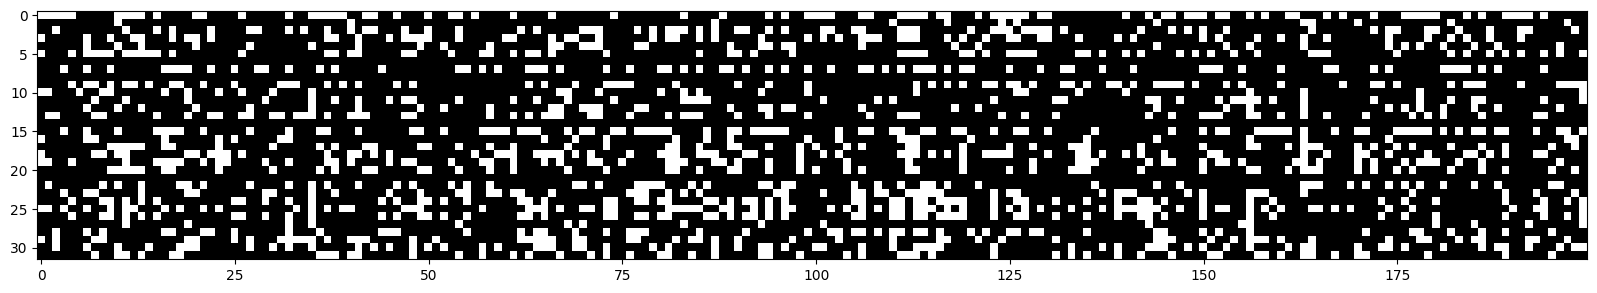

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

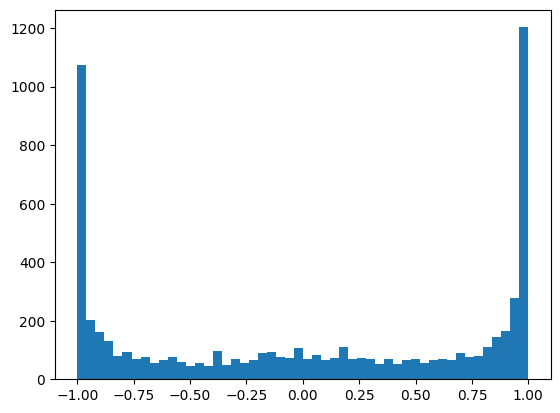

In [12]:
plt.hist(h.view(-1).tolist(), 50 );

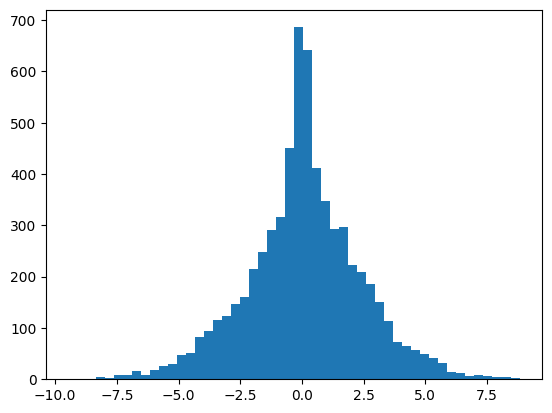

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50 );

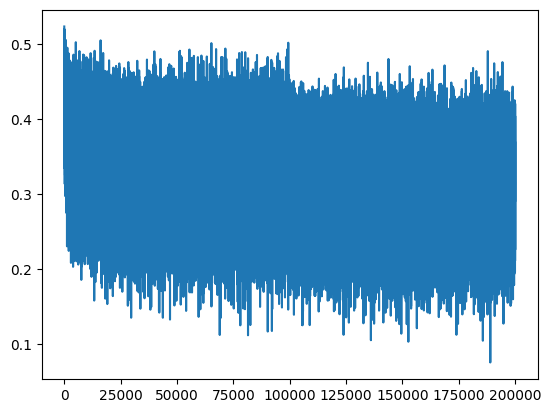

In [14]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0384933948516846
val 2.10172963142395


[Resume here](https://youtu.be/P6sfmUTpUmc?t=1546)

tensor(0.0124) tensor(1.0082)
tensor(-0.0044) tensor(1.0093)


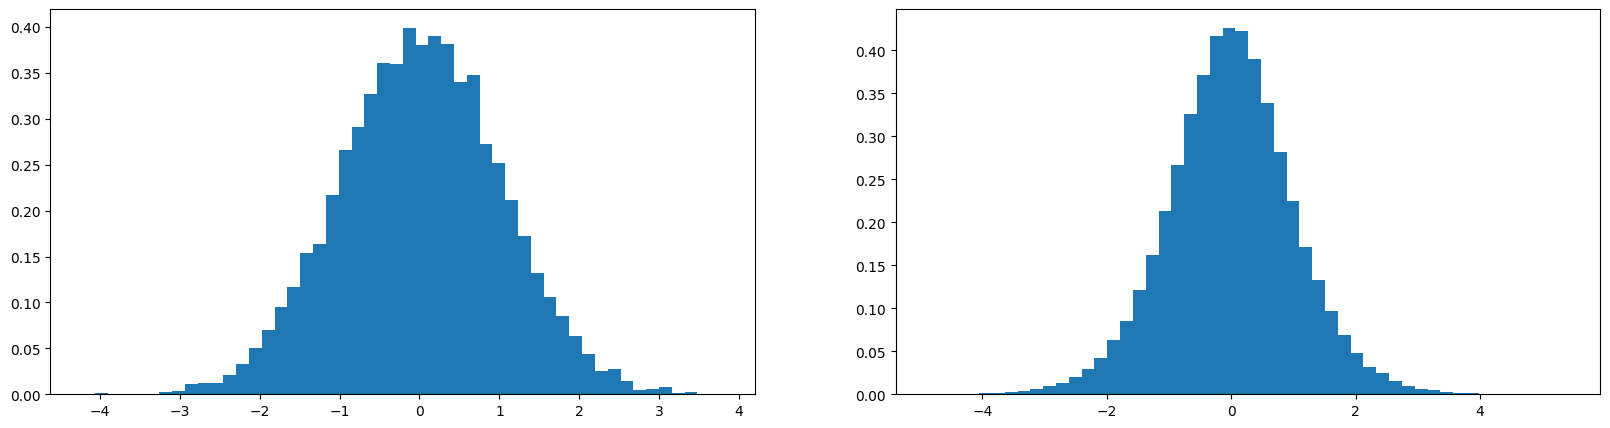

In [16]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5 # the weight can be multiplied with the square root of it's fan-in 

y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


# Here the input is having a certain shape of input, but because
# of it's multiplication with the weight it's standard deviation is increasing which shows it's difference from the mean
# the weight shall be managed in a way to keep the standard deviation to 1 while maintaining it's shape.

# Changes to the weights
# 1. when multiplied with large(15) units it's std is increased
# 2. when squashing with smaller(0.5) units it's std is decreased

# Batch Normalization

![image.png](Batch-normalization.png)

> Every single neuron and it's firing rate will be exactly unifrom gausian on this batch

In [17]:
n_emb = 10 # dimensions of the embedding
n_hidden = 200 # hidden layer dimensions

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / ((n_emb * block_size) ** 0.5) # 0.2 -> activation for tanh is 5/3 / fan_in ** 0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0


# this allows the neurons be more flexible, at the initalization,
# where scale and shifting will add some gain and offset by some bias
# during backpropagation it can be changed for the purpose of better learning.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = C, W1, W2, b2, bngain, bnbias

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [18]:
lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1# +  b1 #hidden layer pre-activation batch normalization has it's own bias, so the bias with the weight is not impactful
    # hpreact_a = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact_a = bngain * (hpreact - bnmeani / bnstdi) + bnbias


    #bnmean_running is an alternative of explicitly calling the overall bnmean and std,
    # using the no_grad() wrapper in cell[50] here the mean and std are updated gently to reach the overall
    # bnmean and bnstd based on the training data, which is later used in the notebook to find the loss.
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact_a) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d} / {max_steps: 7d} - {loss.item():.4f}")

    lossi.append(loss.log10().item())
    # break 

      0 /  200000 - 3.2619
  10000 /  200000 - 1.8376
  20000 /  200000 - 2.3563
  30000 /  200000 - 2.0657
  40000 /  200000 - 2.1987
  50000 /  200000 - 2.3001
  60000 /  200000 - 1.8916
  70000 /  200000 - 2.1307
  80000 /  200000 - 2.0695
  90000 /  200000 - 2.5234
 100000 /  200000 - 2.1799
 110000 /  200000 - 2.2805
 120000 /  200000 - 2.1373
 130000 /  200000 - 1.9688
 140000 /  200000 - 1.9260
 150000 /  200000 - 2.4800
 160000 /  200000 - 2.1642
 170000 /  200000 - 1.7189
 180000 /  200000 - 1.9498
 190000 /  200000 - 2.0019


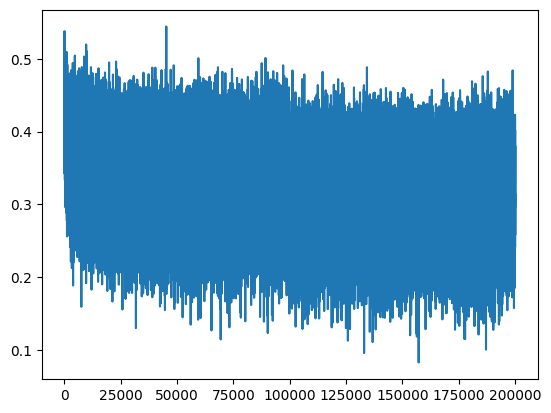

In [20]:
plt.plot(lossi)

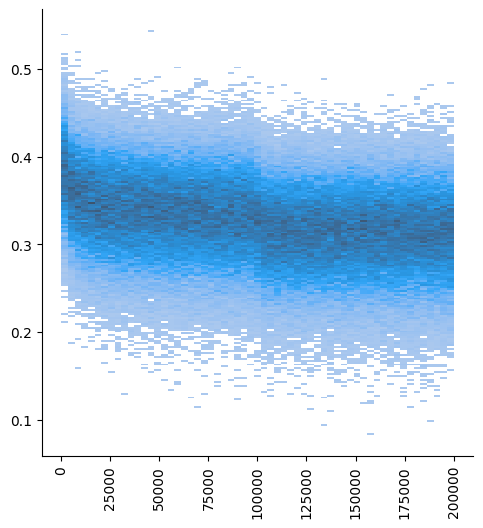

In [24]:
import seaborn as sns
import math

sns.displot(x=range(len(lossi)), y=lossi)
plt.xticks(rotation=90)
plt.show()

# loss_log

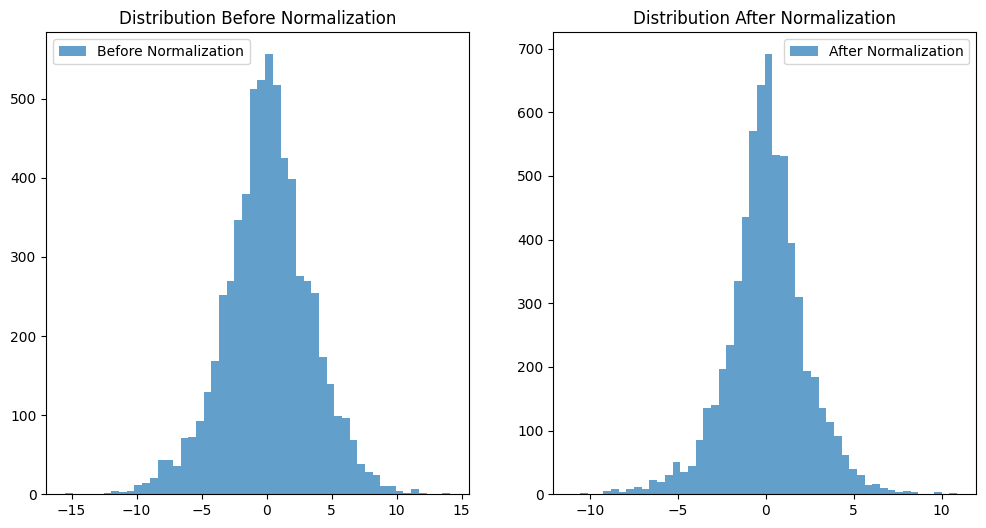

In [25]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hpreact.flatten().detach().numpy(), bins=50, alpha=0.7, label="Before Normalization")
plt.title("Distribution Before Normalization")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(hpreact_a.flatten().detach().numpy(), bins=50, alpha=0.7, label="After Normalization")
plt.title("Distribution After Normalization")
plt.legend()

plt.show()

In [26]:
print("Before normalization:")
print("Mean:", hpreact.mean().item())
print("Std Dev:", hpreact.std().item())

print("After normalization:")
print("Mean:", hpreact_a.mean().item())
print("Std Dev:", hpreact_a.std().item() )

Before normalization:
Mean: 0.1095496192574501
Std Dev: 3.305781841278076
After normalization:
Mean: 0.03911110758781433
Std Dev: 2.2482035160064697


In [27]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact_a = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    hpreact_a = bngain * (hpreact - bnmean_running / bnstd_running) + bnbias
    h = torch.tanh(hpreact_a) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070063829421997
val 2.126920700073242


[Resume here](https://youtu.be/P6sfmUTpUmc?t=3461)

In [29]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chrpahfato.
hevikk.
myli.
thollistassie.
rzhukwu.
perric.
vaehi.
sha.
siah.
madiv.
valexzah.
bron.
cateriyah.
soveric.
vabi.
waverly.
jaryxxxin.
evlivelize.
deci.
abdilebell.


In [155]:
class Linear:

    def __init__(self, fan_in: int, fan_out:int, bias: bool = True):
        """
        Initialization of the Linear Layer where the basic parameters are set
        """
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        """
        Returns the product of the parameters with the input, based on the input and the state of bias
        """
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        """
        Returns the tensors which are  parameters of the Layer considering the bias is used or not.
        """
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [156]:
class BatchNorm1d:

    def __init__(self, dim:int, eps:int=1e-5, momentum:int=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with back props
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers -> trained with momentum update
        self.running_mean =torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        ##### forward pass #####
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        # above we are using the torch.sqrt because we are using the variance instead of std as used earlier
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [157]:
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [171]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [172]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3158
  10000/ 200000: 1.9149
  20000/ 200000: 2.1870
  30000/ 200000: 1.9180
  40000/ 200000: 2.1902
  50000/ 200000: 2.3400
  60000/ 200000: 2.4377
  70000/ 200000: 2.6672
  80000/ 200000: 2.1730
  90000/ 200000: 2.1138
 100000/ 200000: 2.3123
 110000/ 200000: 2.1673
 120000/ 200000: 2.2008
 130000/ 200000: 2.2106
 140000/ 200000: 2.2839
 150000/ 200000: 2.1681
 160000/ 200000: 2.0647
 170000/ 200000: 2.2873
 180000/ 200000: 1.6401
 190000/ 200000: 2.1234


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.22%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.28%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.00%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.22%


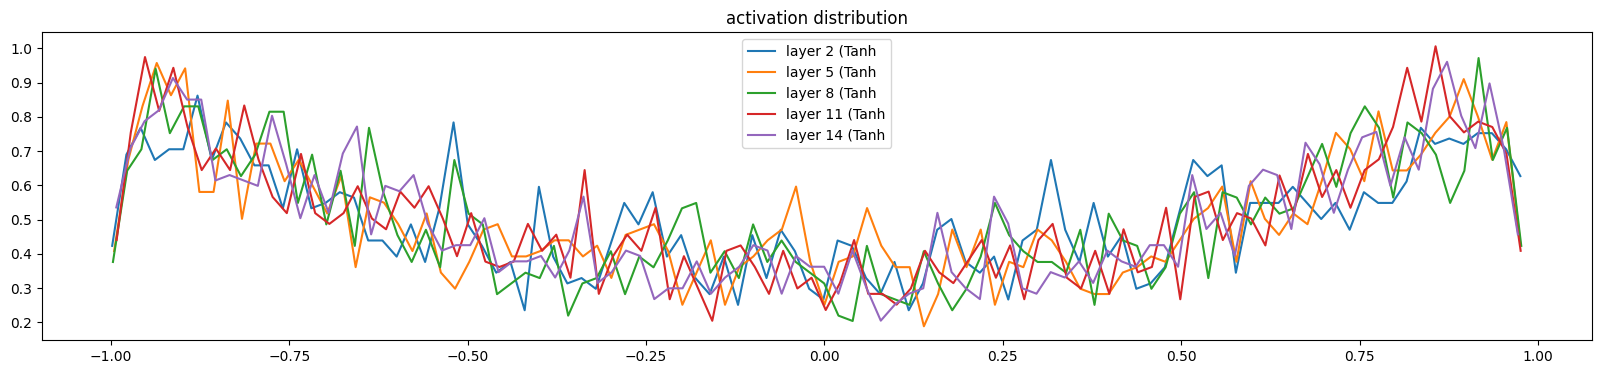

In [166]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

layer 2 (      Tanh): mean +0.000000, std 3.127678e-03
layer 5 (      Tanh): mean +0.000000, std 2.669728e-03
layer 8 (      Tanh): mean -0.000000, std 2.676113e-03
layer 11 (      Tanh): mean -0.000000, std 2.527996e-03
layer 14 (      Tanh): mean +0.000000, std 2.520637e-03


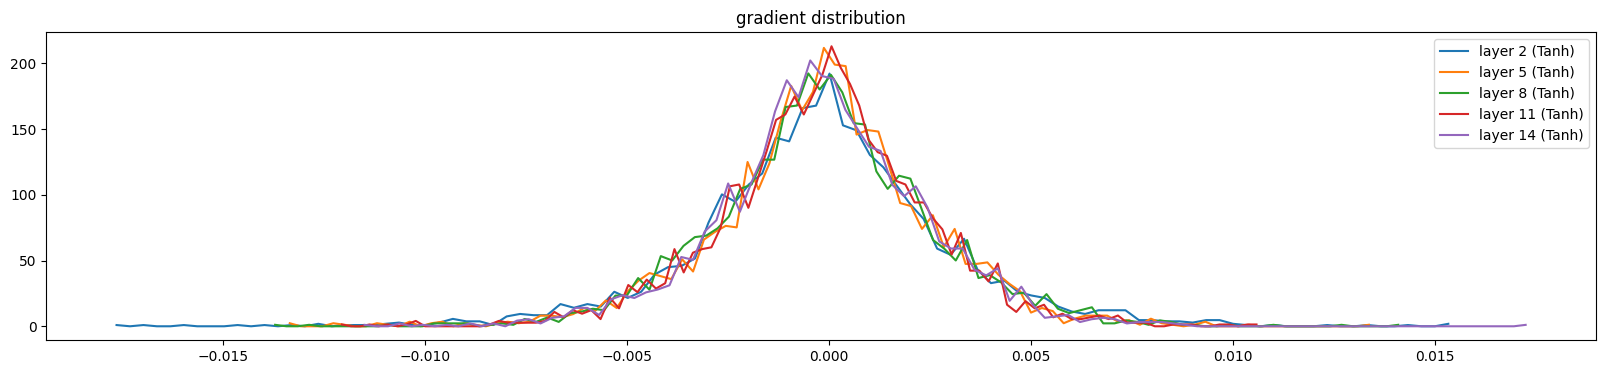

In [167]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean +0.000000 | std 8.334943e-03 | grad:data ratio 8.326319e-03
weight  (30, 100) | mean -0.000104 | std 6.820845e-03 | grad:data ratio 2.182004e-02
weight (100, 100) | mean -0.000134 | std 6.199726e-03 | grad:data ratio 3.707520e-02
weight (100, 100) | mean -0.000063 | std 5.616613e-03 | grad:data ratio 3.329679e-02
weight (100, 100) | mean -0.000022 | std 5.240039e-03 | grad:data ratio 3.121419e-02
weight (100, 100) | mean +0.000041 | std 4.800010e-03 | grad:data ratio 2.858166e-02
weight  (100, 27) | mean -0.000075 | std 8.443508e-03 | grad:data ratio 5.061220e-02


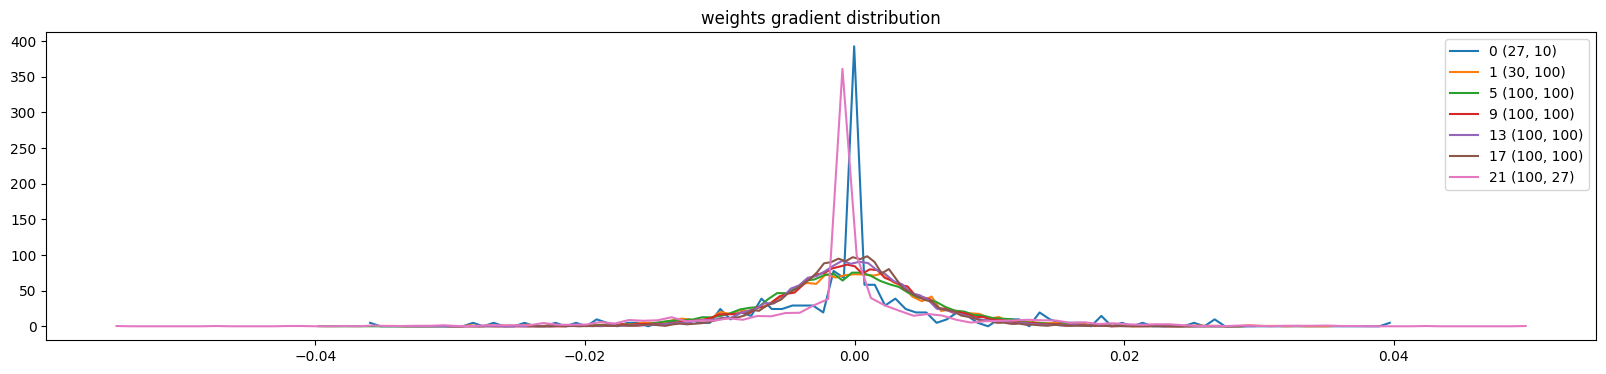

In [168]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

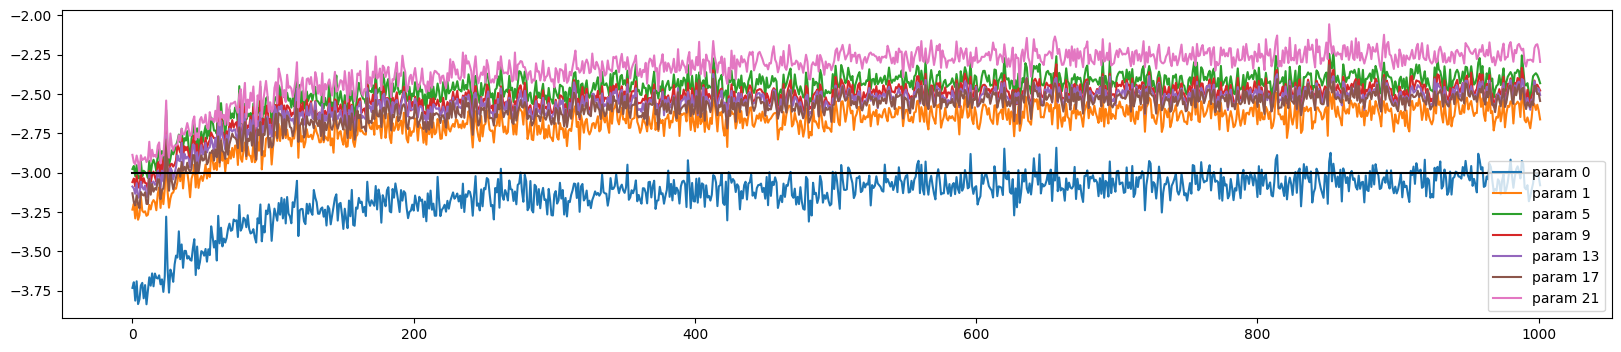

In [170]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The Frequency of change in the parameters is affected when there is change in learning rate, but the other metrics like gradient distribution and activation distribution while implimenting back propagation.

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact_a = bngain * (hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)) + bnbias
    hpreact_a = bngain * (hpreact - bnmean_running / bnstd_running) + bnbias
    h = torch.tanh(hpreact_a) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')